In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Data exploration

(720, 1280, 3)


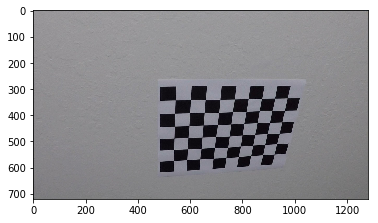

In [2]:
# Data exploration - One of the 20 images used for calibration
img = mpimg.imread("camera_cal/calibration10.jpg")
image_shape = img.shape
print(image_shape)
plt.imshow(img)

To correct the image distortions I first need to identify the locations of the corners on the camera calibration images. These are going to be inputs of my camera calibration function. I used opencv functions findChessboardCorners() and drawChessboardCorners() to do so.

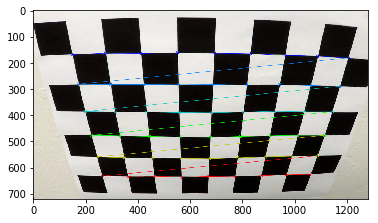

In [3]:
nx = 9
ny = 6

# Read in and make a list of calibration images
images = glob.glob("camera_cal/calibration*.jpg")

#Arrays to store object points and image points from all the images
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

#Prepare object points like (0,0,0), (1,0,0), (2,0,0) .../(7,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) #x, y coordinates

for fname in images:
    #read in each image
    img = mpimg.imread(fname)

    #Convert the image to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Find the chessboard corners
    ret, corners = cv2. findChessboardCorners(gray, (nx,ny), None)

    #If corners are found, add object points, image points
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

        #draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)

In [4]:
# Plot original and transformed image next to each other
def print_image(img1, img2, title1, title2):
    # Plot
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Calibration and Undistortion 

After identifying the corners I am good to calibrate the camera. To do that I use opencv's calibrateCamera() function, I pass the previously calculated objpoints, imgpoints and the shape of the image as arguments. 
The function returns the distortion coefficients and the camera matrix as well which I need to pass as arguments to the undistort() function which returns my undistorted image. Let's try out!

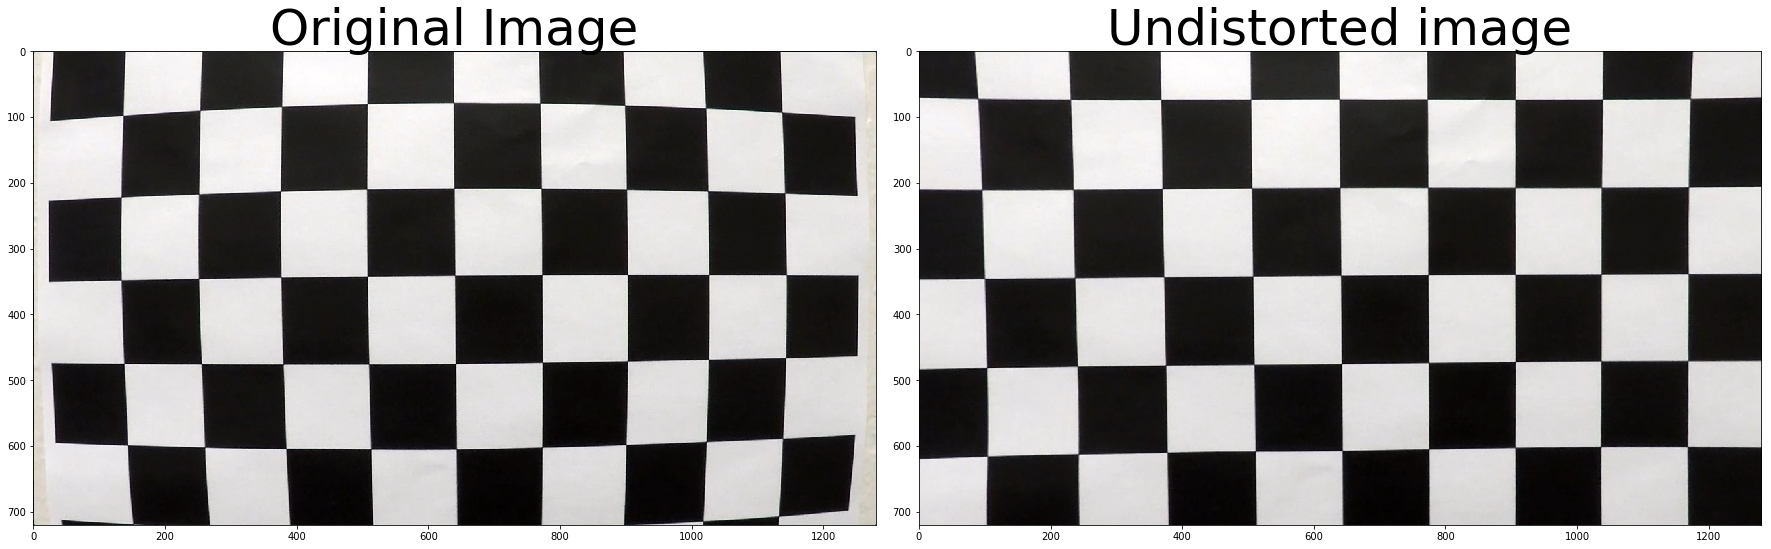

In [5]:
#Camera calibration and undistortion
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

img = mpimg.imread('camera_cal/calibration1.jpg')
dst = undistort(img)

print_image(img, dst, 'Original Image', 'Undistorted image')

Let's test some real-life images before/after undistortion. 

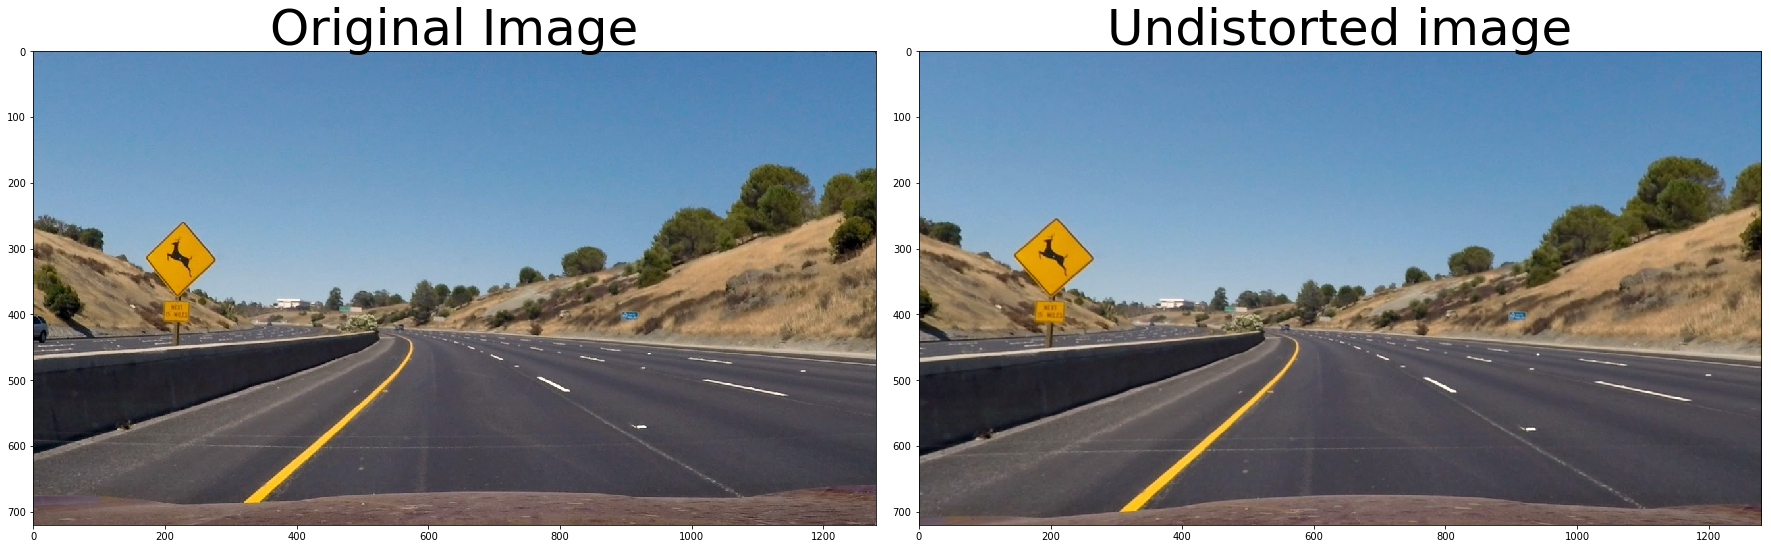

In [6]:
img = mpimg.imread('test_images/test2.jpg')
dst=undistort(img)
print_image(img, dst, 'Original Image', 'Undistorted image')

# Perspective Transform

Perspective transform maps the points in a given image to a different, desired, image points with a new perspective. We are most interested in the bird's-eye view transform that let's us vie a lane from above, this will be useful for calculating the lane curvature. 

In [7]:
# Define perspective transform function
def warp(img):
    
    #Define calibration box in source (original) and destination (desired or warped) coordinates
    img_width = img.shape[1]
    img_height = img.shape[0]
    img_size = (img_width, img_height)
    
    #Four source coordinates
    src = np.float32([[img_width*0.38,img_height*0.67],
                      [img_width*0.63,img_height*0.67],
                      [img_width*0.97,img_height*0.99],
                      [img_width*0.05,img_height*0.9]])
    
    #Four destination coordinates
    dst = np.float32([[img_width*0.05,img_height*0.05],
                      [img_width*0.95,img_height*0.05],
                      [img_width*0.95,img_height*0.95],
                      [img_width*0.05,img_height*0.95]])
    
    #Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

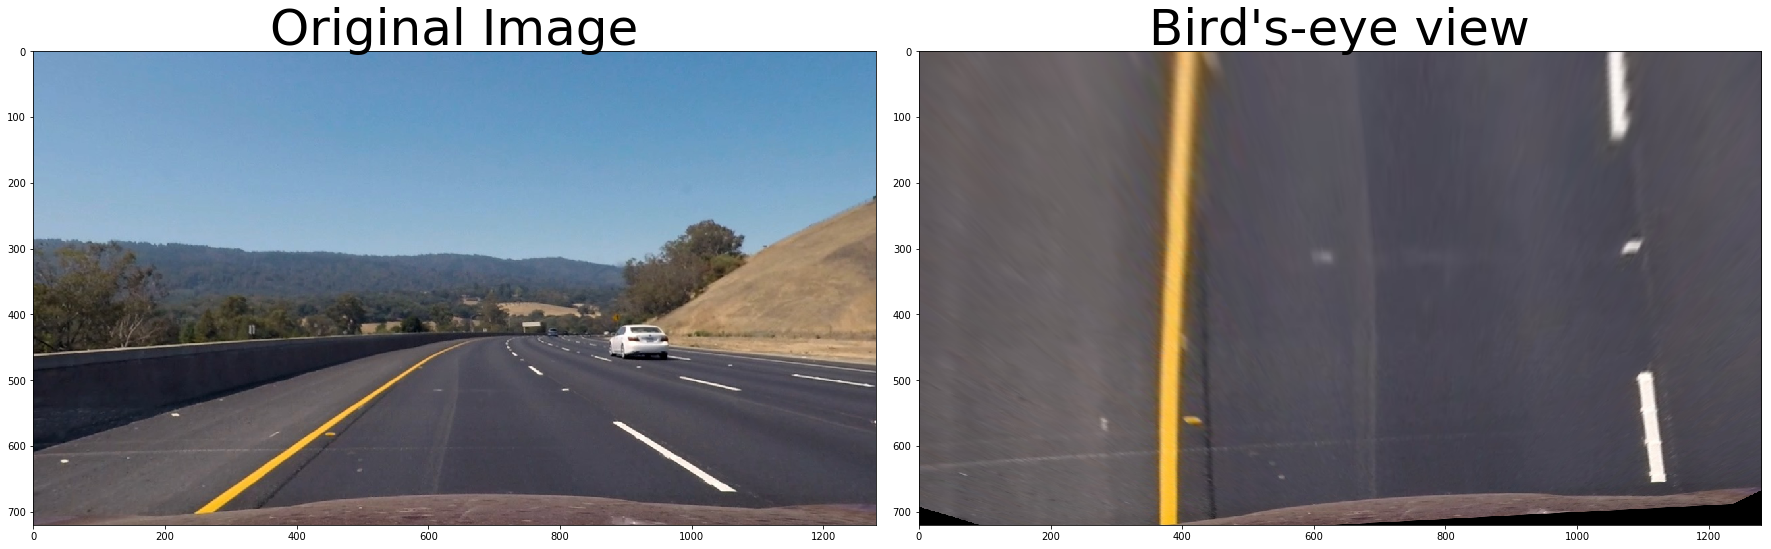

In [8]:
# Test and choose parameters
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Undistort image
img = undistort(img)

# Transform
img_warp = warp(img)

print_image(img, img_warp, 'Original Image', "Bird's-eye view" )